# Diagnosing Cancer Cells

My objective in this notebook is to build a model to predict whether or not a biopsied breast cell is benign (not harmful) or malignant (cancerous), given a set of attributes about the cell.

My approach is to first explore the data:
- check for missing variables,
- check for outliers, and
- investigate sample distribution,
- check whether or not there are any pairwise correlations.

With the predictor size, being small enough, I don't think I will need to do any dimension reduction.


### Some Conclusions
- The user I designed this for is a lab analyst who performs the biopsies.
- The use case is that he/ she will be able to flag the cells to focus attention.
- The cost of predicting a false negative is high so I optimized the model on recall.
- My aim was to build a model that identifies all cancer cases, with a limited misclassifications of false negatives.
- With the data size being so small I took a rigorous approach to model training by doing a 10 fold cross validation. This was to test the stability of my model.
- The results were:
    - a mean cross validated recall of 97%, which proves model stability, and
    - a final recall of 98%.
    
- The next phase is to optimize this model to achieve my objective recall of 100%.




## Loading in data and packages

In [21]:
# Needed packages
from urllib.request import urlopen    # to open web links
import pandas as pd                   # for data processing
import seaborn as sns                 # for data visualization
import matplotlib.pyplot as plt       # for plotting

import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, f1_score, precision_score, confusion_matrix


In [2]:
# Loading data
URL_data = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
df = pd.read_csv(urlopen(URL_data), header=None)
# df = pd.read_csv('breast-cancer-wisconsin.data', header = None)    #For when not connected to the internet

df.shape
df.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2



I noticed that the data has no heading, so I am going to assign the appropriate headings now.

Attribute Information:
1. Sample code number: id number 
2. Clump Thickness 
3. Uniformity of Cell Size
4. Uniformity of Cell Shape
5. Marginal Adhesion
6. Single Epithelial Cell Size
7. Bare Nuclei
8. Bland Chromatin 
9. Normal Nucleoli 
10. Mitoses
11. Class

The 11th attribute, "Class"is the label data, where an observation is classified as 2 for benign, 4 for malignant. Attributes 2 to 10 are features which gives measurements of the biopsied cell (they all range from 1-10). This is a classification modeling problem.

In [3]:
# Assigning column names
df.columns = ['ID', 'clump_thick', 'cell_size', 'cell_shape',
               'margin_adhesion', 'cell_size_epi', 'bare_nuclei',
               'bland_chromatin', 'normal_nucleoli', 'mitoses', 'Class']

The label, "Class", is coded as 2 for benign, and 4 for malignant. This seems arbitrary to me, so I am going to make it much more intuitive as:
- 0: benign
- 1: malignant

In [4]:
# Converting beinign classification to "0", and malignant to "1".
df['Class'] = df['Class'].map({2:0, 4:1})
df['Class'].value_counts()

0    458
1    241
Name: Class, dtype: int64





### Data Exploration

Now, I am going to check out data structure, as well as investiage if there are any missing data

In [5]:
#checking a snapshot of the data
df.head()

,ID,clump_thick,cell_size,cell_shape,margin_adhesion,cell_size_epi,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [6]:
# checking data structure
df.dtypes

ID                  int64
clump_thick         int64
cell_size           int64
cell_shape          int64
margin_adhesion     int64
cell_size_epi       int64
bare_nuclei        object
bland_chromatin     int64
normal_nucleoli     int64
mitoses             int64
Class               int64
dtype: object

It says here that the "bare nuclei" is an object. From the snapshot above, I would have expected it to also been an integer, so I am going to investigate what is going on.

In [7]:
# Checking a summary of the "bare nuclei" feature
df['bare_nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

Turns out that there are 16 instances of missing data, which are represented as "?". I am going to delete those observations and then convert the column to an integer.

In [8]:
df = df[~(df == '?').any(axis=1)]     # delete "?"
df["bare_nuclei"] = pd.to_numeric(df["bare_nuclei"])  # convert to integer
df.shape            #there are now 683 observations

/home/priscilla/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


(683, 11)

I will like to know now, if there are any other missing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 11 columns):
ID                 683 non-null int64
clump_thick        683 non-null int64
cell_size          683 non-null int64
cell_shape         683 non-null int64
margin_adhesion    683 non-null int64
cell_size_epi      683 non-null int64
bare_nuclei        683 non-null int64
bland_chromatin    683 non-null int64
normal_nucleoli    683 non-null int64
mitoses            683 non-null int64
Class              683 non-null int64
dtypes: int64(11)
memory usage: 64.0 KB


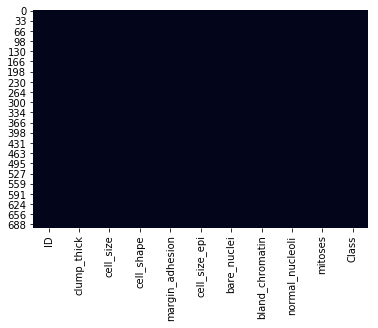

In [9]:
df.info()  # no missing data
sns.heatmap(df.isnull(), cbar=False)

In [10]:
# Separating out label variable 
y = df['Class']


# Separating out the predictors
x = df.drop(['ID', 'Class'],axis = 1 )
x.shape
x.describe()

,clump_thick,cell_size,cell_shape,margin_adhesion,cell_size_epi,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000




## Data Visualizations

To have a better sense of my data, I am going to explore its distributions with different visualizations.

#### Label data

Benign biopsies:  444 ( 65 %)
Malignant biopsies:  239 ( 35 %)


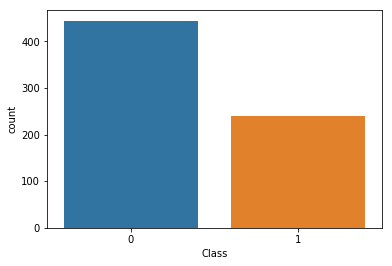

In [11]:
# Exploring distribution of y
B, M = y.value_counts()
B_percent = round(B/(B+M)*100)
M_percent = round(M/(M+B)*100)
print('Benign biopsies: ',B, '(', B_percent, '%)' )
print('Malignant biopsies: ',M,'(', M_percent, '%)')

# Plotting the distribution of y
sns.countplot(y,label="Count")

#### Features data
Now, I will like to know the distribution of the different features. To begin, I will like to visualize the summary statistics of the features, and how they vary with the different classes of the label data. To do this, I am going to use a boxplot.

##### Boxplot

In [72]:
x.head()

,clump_thick,cell_size,cell_shape,margin_adhesion,cell_size_epi,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

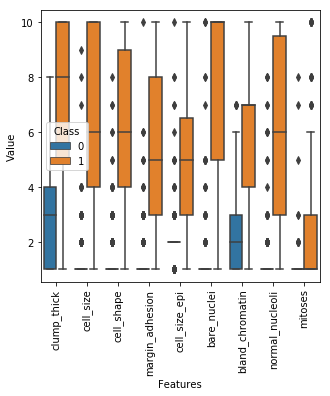

In [75]:
# Recombining data and melting dataframe
data = pd.concat([y,x],axis=1)
data = pd.melt(data,id_vars="Class",
                    var_name="Features",
                    value_name='Value')

plt.figure(figsize=(5,5))
sns.boxplot(x="Features", y="Value", hue="Class", data=data)
plt.xticks(rotation=90)

From the snapshot the boxplot gives, there seems to be good separation of features between classes. There are many outliers too. To see a full distribution of the data, I am going to construct violin plots.

##### Violin Plot

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

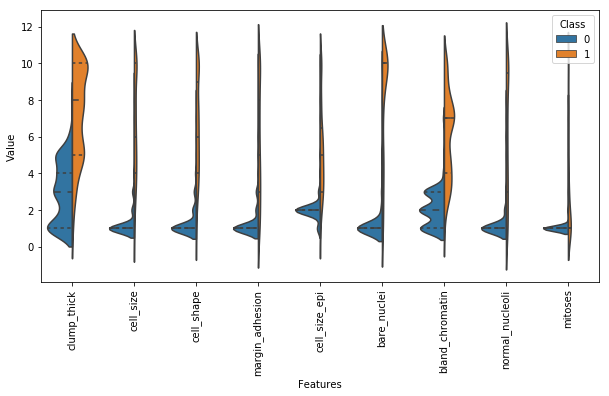

In [74]:
plt.figure(figsize=(10,5))
sns.violinplot(x="Features", y="Value", hue="Class", data=data,split=True, inner="quart")
plt.xticks(rotation=90)

The violin plot shows that the outliers of the malignant class registered on the boxplot is from its generally large variances. 

I am now going to investigate any pairwise correlation between predictors.
### Pairwise correlation

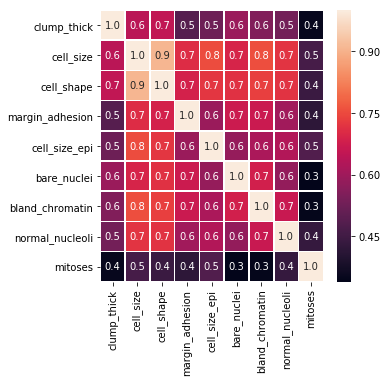

In [18]:
#correlation map
f,ax = plt.subplots(figsize=(5, 5))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

Cell size is correlated with many other features: 
- cell size and cell shape (90%)
- cell size and cell size epit (80%)
- cell size and bland chromatin (80%)

### Classification

- I am going to use the random forest classsifier for analyses because it is robust against overfitting. 
- With my sample size being relatively small, I am going to perform a 10-fold cross validation. 
- I am doing this so I can rigorously test the stability of my model. 
- Classes are imbalanced so I am going to stratify my sampling during split to ensure representative frequencies in each split. I am also going to apply weights to model sampling during training.
- In our context, the cost of predicting a false negative is high, so I am going to optimize my model training on recall.

In [62]:
# Function to perform cross validation
def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

In [64]:
# Setting a range of values to tune on
clf = RandomForestClassifier(n_jobs=-1, class_weight="balanced")

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [5,9, 10,15, 20,30, 50, 100],
    'max_depth': [3, 5, 15, 25]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


In [65]:
# Splitting data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=78)

In [66]:
# Actual model development
grid_search_clf = grid_search_wrapper(refit_score='recall_score') 


/home/priscilla/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best params for recall_score
{'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 30}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       106         4
pos         2        59


In [67]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth',  'param_min_samples_split', 'param_n_estimators']].round(3).head()


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_min_samples_split,param_n_estimators
72,0.952,0.944,0.963,25,3,5
83,0.947,0.961,0.967,25,5,15
78,0.946,0.961,0.967,25,3,50
41,0.944,0.983,0.973,5,10,9
51,0.943,0.977,0.971,15,3,15


Accuracy is:  0.9824561403508771


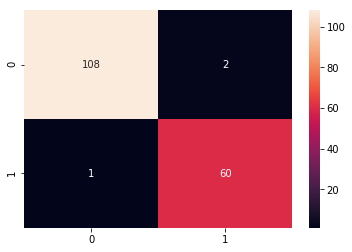

In [61]:
# Building one cohesive on dataset model

#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(n_estimators=9, random_state=67)      
clr_rf = clf_rf.fit(X_train,y_train)

ac = accuracy_score(y_test,clf_rf.predict(x_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(x_test))
sns.heatmap(cm,annot=True,fmt="d")